# TCN

In [1]:
#import os
import gc
#from datetime import datetime
#import time

#import math
#from itertools import product

import numpy as np
import pandas as pd

#from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.arima_model import ARMA, ARIMA
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import statsmodels.api as sm

#from sklearn.model_selection import KFold
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import RobustScaler, StandardScaler

#from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# https://github.com/philipperemy/keras-tcn
from tcn import TCN

import tensorflow_probability as tfp

#from plotly.subplots import make_subplots
#import plotly.express as px
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
#data_path = '/kaggle/input/'
data_path = '../data/'

## Artificial Neural Networks Methods

In [3]:
DEBUG = True
N_ASSETS = 1
WINDOW_SIZE = 15
BATCH_SIZE = 1024
PCT_VALIDATION = 10 # last 10% of the data are used as validation set

### Data Preparation (Building the Time Series Model)

#### Loading

Loading data and converting timestamps

In [4]:
asset_details = pd.read_csv(data_path + 'g-research-crypto-forecasting/asset_details.csv')

In [5]:
asset_details.sort_values(by='Asset_ID')

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [6]:
train = pd.read_csv(data_path + "g-research-crypto-forecasting/train.csv")

In [7]:
train.columns

Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP', 'Target'],
      dtype='object')

In [8]:
train = train[train.Asset_ID == 1]

In [9]:
# Convert timestamp
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,2018-01-01 00:01:00,1,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093,-0.014643
10,2018-01-01 00:02:00,1,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591,-0.015037
18,2018-01-01 00:03:00,1,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014,-0.010309
26,2018-01-01 00:04:00,1,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101,-0.008999
34,2018-01-01 00:05:00,1,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842,-0.008079
...,...,...,...,...,...,...,...,...,...,...
24236739,2021-09-20 23:56:00,1,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,NaN
24236753,2021-09-20 23:57:00,1,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,NaN
24236767,2021-09-20 23:58:00,1,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,NaN
24236781,2021-09-20 23:59:00,1,4047.0,42839.012802,43042.160000,42818.10,43017.277143,138.335477,42935.761938,NaN


#### Reindexing and sorting

Asset-wise reindexing, performing a forward fill when possible, else a backfill. We create a column `is_real` to note whether a row is existant in the original dataset or added due to reindexing.

In [10]:
# maybe target should not be filled. The filling has to be re-examined

In [11]:
train.index = train.timestamp
train.sort_index(inplace=True)
train['is_real'] = True
ind = train.index.unique()

def reindex(df):
    res = df.reindex(pd.date_range(ind.min(), ind.max(), freq='min'))
    res['is_real'].fillna(False, inplace=True)
    res['timestamp'] = res.index
    res = res.fillna(method="ffill").fillna(method="bfill")
    return res

train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_values(by=['timestamp', 'Asset_ID'])
gc.collect()

0

In [12]:
train.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,is_real
2018-01-01 00:01:00,2018-01-01 00:01:00,1.0,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,True
2018-01-01 00:02:00,2018-01-01 00:02:00,1.0,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,True
2018-01-01 00:03:00,2018-01-01 00:03:00,1.0,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,True
2018-01-01 00:04:00,2018-01-01 00:04:00,1.0,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,True
2018-01-01 00:05:00,2018-01-01 00:05:00,1.0,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,True
2018-01-01 00:06:00,2018-01-01 00:06:00,1.0,554.0,13717.714,14000.7,13520.00,13717.112,70.805776,13706.952030,-0.004422,True
2018-01-01 00:07:00,2018-01-01 00:07:00,1.0,546.0,13720.922,14001.4,13501.01,13670.940,70.762103,13683.843336,-0.008873,True
2018-01-01 00:08:00,2018-01-01 00:08:00,1.0,437.0,13669.246,13914.6,13504.99,13721.348,78.298555,13701.600413,-0.008492,True
2018-01-01 00:09:00,2018-01-01 00:09:00,1.0,288.0,13713.412,13948.9,13539.99,13720.260,60.100796,13720.524584,-0.006282,True
2018-01-01 00:10:00,2018-01-01 00:10:00,1.0,270.0,13713.610,13948.5,13530.00,13719.902,56.578007,13711.904983,-0.003889,True


#### VWAP clipping

In [13]:
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)

#### Feature engineering

In [14]:
def feature_eng(_df, row = False):
    #_df = df.copy()
    
    _df['Spread'] = _df['High'] - _df['Low']
    _df['Close-Open'] = _df['Close'] - _df['Open']

    _df['Upper_Shadow'] = _df['High'] - np.maximum(_df['Close'], _df['Open'])
    _df['Lower_Shadow'] = np.minimum(_df['Close'], _df['Open']) - _df['Low']
    
    _df['High/Low'] = _df['High'] / _df['Low']
    _df['log_High/Low'] = np.log(_df['High/Low'])
    
    _df['Close/Open'] = _df['Close'] / _df['Open']
    _df['log_Close/Open'] = np.log(_df['Close/Open'])

    _df['Volume/Count'] = _df['Volume'] / (_df['Count'] + 1)

    _df['LOGVOL'] = np.log(1. + _df['Volume'])
    _df['LOGCNT'] = np.log(1. + _df['Count'])

    _df['Mean'] = _df[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
    _df['High/Mean'] = _df['High'] / _df['Mean']
    _df['Low/Mean'] = _df['Low'] / _df['Mean']

    _df['Median'] = _df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    _df['High/Median'] = _df['High'] / _df['Median']
    _df['Low/Median'] = _df['Low'] / _df['Median']

    """################################### ???

        _df['RNG'] = (_df['High'] - _df['Low']) / _df['VWAP']
        _df['MOV'] = (_df['Close'] - _df['Open']) / _df['VWAP']
        _df['CLS'] = (_df['Close'] - _df['VWAP']) / _df['VWAP']

    ################################### ???

        _df['gtrade'] = _df['Close-Open'] / _df['Count']
        _df['shadow1'] = _df['Close-Open'] / (_df['Volume'] + 1)
        _df['shadow3'] = _df['Upper_Shadow'] / (_df['Volume'] + 1)
        _df['shadow5'] = _df['Lower_Shadow'] / (_df['Volume'] + 1)

        _df['diff1'] = _df['Volume'] - _df['Count'] # ?????

        _df['mean1'] = (_df['shadow5'] + _df['shadow3']) / 2
        _df['mean2'] = (_df['shadow1'] + _df['Volume']) / 2
        _df['mean3'] = (_df['Close-Open'] + _df['gtrade']) / 2
        _df['mean4'] = (_df['diff1'] + _df['Upper_Shadow']) / 2
        _df['mean5'] = (_df['diff1'] + _df['Lower_Shadow']) / 2"""

    return _df

Get the features

In [15]:
train = feature_eng(train)

some params needed for the model, sampling, etc.

In [16]:
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)

In [17]:
feature_cols = train.columns.drop(['Asset_ID', 'Target', 'timestamp', 'is_real'])

In [18]:
feature_cols

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Spread',
       'Close-Open', 'Upper_Shadow', 'Lower_Shadow', 'High/Low',
       'log_High/Low', 'Close/Open', 'log_Close/Open', 'Volume/Count',
       'LOGVOL', 'LOGCNT', 'Mean', 'High/Mean', 'Low/Mean', 'Median',
       'High/Median', 'Low/Median'],
      dtype='object')

In [19]:
len(feature_cols)

24

#### Managing added timestamps

non-real data features are set to 0 which are then masked by the model

In [20]:
train.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,log_Close/Open,Volume/Count,LOGVOL,LOGCNT,Mean,High/Mean,Low/Mean,Median,High/Median,Low/Median
2018-01-01 00:01:00,2018-01-01 00:01:00,1.0,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,...,0.001082,0.137174,3.482779,5.438079,13841.3200,1.012461,0.987342,13842.685,1.012361,0.987244
2018-01-01 00:02:00,2018-01-01 00:02:00,1.0,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,...,-0.000501,0.131553,3.467186,5.463832,13848.8595,1.014690,0.987807,13831.569,1.015958,0.989042
2018-01-01 00:03:00,2018-01-01 00:03:00,1.0,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,...,-0.001635,0.104087,4.026455,6.270988,13806.6535,1.014033,0.985105,13812.607,1.013596,0.984680
2018-01-01 00:04:00,2018-01-01 00:04:00,1.0,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,...,-0.002501,0.088946,3.683378,6.077642,13786.4580,1.015417,0.984755,13785.276,1.015504,0.984839
2018-01-01 00:05:00,2018-01-01 00:05:00,1.0,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,...,-0.002989,0.146032,4.695939,6.610696,13750.3135,1.014951,0.985755,13745.457,1.015310,0.986103
2018-01-01 00:06:00,2018-01-01 00:06:00,1.0,554.0,13717.714,14000.7,13520.00,13717.112,70.805776,13706.952030,-0.004422,...,-0.000044,0.127578,4.273965,6.318968,13738.8815,1.019057,0.984068,13717.413,1.020652,0.985609
2018-01-01 00:07:00,2018-01-01 00:07:00,1.0,546.0,13720.922,14001.4,13501.01,13670.940,70.762103,13683.843336,-0.008873,...,-0.003649,0.129364,4.273357,6.304449,13723.5680,1.020245,0.983783,13695.931,1.022304,0.985768
2018-01-01 00:08:00,2018-01-01 00:08:00,1.0,437.0,13669.246,13914.6,13504.99,13721.348,78.298555,13701.600413,-0.008492,...,0.003804,0.178764,4.373220,6.082219,13702.5460,1.015476,0.985583,13695.297,1.016013,0.986104
2018-01-01 00:09:00,2018-01-01 00:09:00,1.0,288.0,13713.412,13948.9,13539.99,13720.260,60.100796,13720.524584,-0.006282,...,0.000499,0.207961,4.112525,5.666427,13730.6405,1.015896,0.986115,13716.836,1.016918,0.987107
2018-01-01 00:10:00,2018-01-01 00:10:00,1.0,270.0,13713.610,13948.5,13530.00,13719.902,56.578007,13711.904983,-0.003889,...,0.000459,0.208775,4.053141,5.602119,13728.0030,1.016062,0.985577,13716.756,1.016895,0.986385


#### Generating training samples

In [21]:
train_data = train[feature_cols].values
train_data = train_data.reshape(-1, N_ASSETS, train_data.shape[-1])

In [22]:
train_data.shape

(1956960, 1, 24)

Samples with a duration of WINDOW_SIZE records (minutes) will be formed from the train array. Each sample has a target vector corresponding to the final index if WINDOW_SIZE record.

In [23]:
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)
    def __len__(self): return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        for i in range(self.batch_size):
            start_ind = self.batch_size * idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])
        return np.array(batch_x), np.array(batch_y)

In [24]:
X_train, X_test = train_data[:-len(train_data)//PCT_VALIDATION], train_data[-len(train_data)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train_data)//PCT_VALIDATION], targets[-len(train_data)//PCT_VALIDATION:]

In [25]:
train_generator = sample_generator(X_train, y_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: (1024, 15, 1, 24)
Target shape: (1024, 1)


### Metrics and Loss functions

In [26]:
#Correlations for predicted and real
def MaxCorrelation(y_true,y_pred): 
    return -tf.math.abs(tfp.stats.correlation(y_pred, y_true, sample_axis=None, event_axis=None))

def Correlation(y_true,y_pred): 
    return tf.math.abs(tfp.stats.correlation(y_pred, y_true, sample_axis=None, event_axis=None))

#Masked losses
def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true=y_true_masked, y_pred=y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true=y_true_masked, y_pred=y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

### TCN

#### 1-Layered TCN with Global Average Pool

##### Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variable VERBOSE. The variable VERBOSE=1 or 2 will display the training and validation loss for each epoch as text.

In [27]:
#Model
DILATION = [2, 4, 8, 16]
NB_FILTERS = 16

def get_model(n_assets=N_ASSETS):
    x_input = keras.Input(shape=(train_generator[0][0].shape[1], n_assets, train_generator[0][0].shape[-1]))
    branch_outputs = []
    
    for i in range(n_assets):
        a = layers.Lambda(lambda x: x[:,:, i])(x_input) # Slicing the ith asset:
        a = layers.Masking(mask_value=0.)(a)
        a = tf.keras.layers.BatchNormalization()(a)
        a = TCN(nb_filters=NB_FILTERS, return_sequences=True, dilations=DILATION)(a)
        a = layers.GlobalAvgPool1D()(a)
        branch_outputs.append(a)
        
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units=128)(x)
    out = layers.Dense(units=n_assets)(x)
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=masked_mse, metrics=[Correlation])
    return model

model = get_model()
model.summary()

2022-01-05 16:20:24.235620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:20:24.243690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:20:24.244727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 16:20:24.246471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1, 24)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 15, 24)            0         
_________________________________________________________________
masking (Masking)            (None, 15, 24)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 24)            96        
_________________________________________________________________
tcn (TCN)                    (None, 15, 16)            7056      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
concatenate (Concatenate)    (None, 16)                0     

In [28]:
tf.keras.utils.plot_model(get_model(n_assets=1), show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [29]:
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min', restore_best_weights=True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

##### Training and testing

In [30]:
EPOCHS = 200
history = model.fit(train_generator, validation_data=(val_generator), epochs=EPOCHS, callbacks=[lr, estop])

Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


2022-01-05 16:20:25.450899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 16:20:27.291455: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


1720/1720 [==============================] - 345s 198ms/step - loss: 4.8372e-04 - Correlation: 0.0774 - val_loss: 0.0037 - val_Correlation: 0.1055
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009919998, shape=(), dtype=float32).
1720/1720 [==============================] - 340s 198ms/step - loss: 1.4139e-05 - Correlation: 0.0873 - val_loss: 5.0069e-05 - val_Correlation: 0.0904
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009840637, shape=(), dtype=float32).
1720/1720 [==============================] - 340s 198ms/step - loss: 1.1490e-05 - Correlation: 0.0880 - val_loss: 0.0113 - val_Correlation: 0.1103
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00097619096, shape=(), dtype=float32).
1720/1720 [==============================] - 340s 198ms/step - loss: 7.2941e-06 - Correlation: 0.0865 - val_loss: 0.0028 - val_Correlation: 0.1171
Epoch 5/200

Epoch 00005: LearningRate

In [36]:
model.save('models/tcn/tcn')

2022-01-05 17:39:58.826068: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/tcn/tcn/assets


INFO:tensorflow:Assets written to: models/tcn/tcn/assets


In [31]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    histories = pd.DataFrame(history.history)
    epochs = list(range(1, len(histories)+1))
    loss = histories['loss']
    val_loss = histories['val_loss']
    correlation = histories['Correlation']
    val_correlation = histories['val_Correlation']
    ax[0].plot(epochs, loss, label='Train Loss')
    ax[0].plot(epochs, val_loss, label='Val Loss')
    ax[0].set_title('Losses')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper right')
    ax[1].plot(epochs, correlation, label='Train Correlation')
    ax[1].plot(epochs, val_correlation, label='Val Correlation')
    ax[1].set_title('Correlations')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    fig.show()
gc.collect()

33

/tmp/ipykernel_11609/2599010004.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


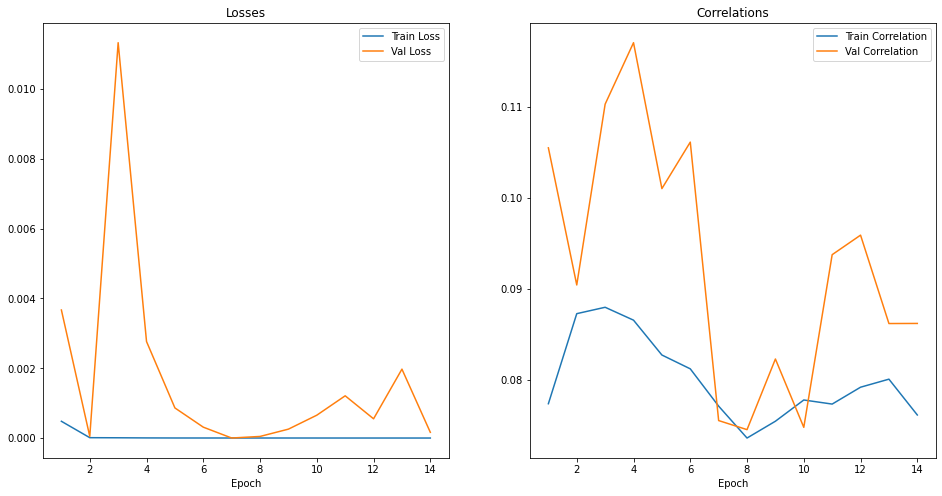

In [32]:
plot_training_history(history)

In [33]:
predictions = model.predict(val_generator)

In [34]:
def prediction_details(predictions, y_test, asset_details, assets):
    print('Asset:    Corr. coef.')
    print('---------------------')
    for i, asset in enumerate(assets):
        # drop first 14 values in the y_test, since they are absent in val_generator labels
        y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
        y_pred = np.squeeze(predictions[:, i])
        real_target_ind = np.argwhere(y_true != 0)
        asset_name = asset_details[asset_details.Asset_ID == asset]['Asset_Name'].item()
        print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0, 1]:.4f}")
        plt.plot(y_true, label='Target')
        plt.plot(y_pred, label='Prediction')
        plt.xlabel('Time')
        plt.ylabel('Target')
        plt.title(asset_name)
        plt.legend()
        plt.show()

Asset:    Corr. coef.
---------------------
Bitcoin: -0.0189


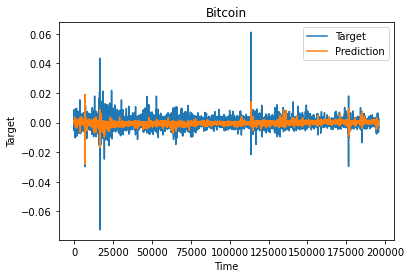

In [35]:
prediction_details(predictions=predictions, y_test=y_test, asset_details=asset_details, assets=train.Asset_ID.astype(int).unique())